Bu not defterinde (https://www.kaggle.com/balraj98/deepglobe-land-cover-classification-dataset) Uydu Görüntülerinden Arazi Örtüsü Sınıflandırması için [DeepLabV3+](https://arxiv.org/abs/1802.02611) kullanıyoruz.

##Ön İşlemler

### 1) *Kütüphaneler 📚⬇

In [ ]:
!python --version

In [ ]:
!pip install --force-reinstall opencv-python==4.5.3.56

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
!pip install lap

In [ ]:
!pip install Cython

In [ ]:
!pip install cython-bbox

In [ ]:
!pip install pandas

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torchvision.transforms
from torch.utils.data import DataLoader
import albumentations as album

import segmentation_models_pytorch as smp

import pickle

### 2) *Google Colab için Google Drive dizin bağlantısı.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 3) *Sabitler

In [ ]:
WORKINGNUMBER = 'W05softmaxNoCrop'
VALIDATION_DATA_RATE = 0.1

TRAINING = True
TARGET_EPOCHS = 5
LEARNING_RATE = 0.00008
TRAIN_BATCH_SIZE = 32

TEST_MODEL_FILE_NAME = '/nofile.pth'
VISUALIZE_TEST = True;
VISUALIZE_VALID = True;
VISUALIZE_TEST_ALL = True;

#Kabul edilen aktivasyon fonksiyonları “sigmoid”, “softmax”, “logsoftmax”, “tanh”, “identity”, "softmax2d".
ACTIVATION = 'softmax'

#Ekran kartı tespit edilirse cuda çekirdeği üzerinde çalışacak.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE: '+str(DEVICE)) #Ekran kartı mı işlemci mi?

#Bu kısım projeye özeldir. Değiştirme.
IS_META_DATA_PATH_JPG = False;
IS_META_DATA_PATH_JPG_JUST_ONE_RUN_ENOUGH = False;
MAIN_FOLDER_DIR = '/content/drive/MyDrive'
WORKING_FOLDER_DIR = '/Forest Aerial Images for Segmentation'
DATA_DIR = MAIN_FOLDER_DIR+WORKING_FOLDER_DIR

PRETRAINED_MODELS_DIR = DATA_DIR+"/PreTrainedModels/"+WORKINGNUMBER
if not os.path.exists(PRETRAINED_MODELS_DIR):
    os.makedirs(PRETRAINED_MODELS_DIR)

METADATA_CSV_FILE_NAME = 'meta_data.csv'
CLASSES_CSV_FILE_NAME = 'class_dict.csv'

DEVICE: cpu


### 4) *Verisetinin okunması 📁

#### Metadatanın Çekilmesi ve Etiketli Verinin Eğitim ve Doğrulama İçin Bölünmesi

In [ ]:
from operator import length_hint
metadata_df = pd.read_csv(os.path.join(DATA_DIR, METADATA_CSV_FILE_NAME))
metadata_df = metadata_df[['image', 'mask']]
metadata_df['image'] = metadata_df['image'].apply(lambda img_pth: os.path.join(DATA_DIR+'/Forest Segmented/images/', img_pth))
metadata_df['mask'] = metadata_df['mask'].apply(lambda img_pth: os.path.join(DATA_DIR+'/Forest Segmented/masks/', img_pth))
# Veri setini karma işlemi
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Png olmayan binary maskelerin treshold değerinin alınıp, png olarak kaydedilmesi.
if (IS_META_DATA_PATH_JPG_JUST_ONE_RUN_ENOUGH):
  for maskpath in metadata_df.T.values[1]:
    jpgimage = cv2.imread(maskpath)
    print('Original path:'+maskpath) #Okunan dosya yolu (jpg)
    ret,thresimg = cv2.threshold(jpgimage, 127, 255, cv2.THRESH_BINARY)
    maskpath = maskpath.split('.')[0]+'.png'

    if not os.path.exists(PRETRAINED_MODELS_DIR):
      os.makedirs(PRETRAINED_MODELS_DIR)

    cv2.imwrite(os.path.join(maskpath), thresimg)
    #visualize(original_image = jpgimage,thres_image = thresimg)
    print('Save path: '+maskpath) #Png olarak kaydedilen görüntünün dosya yolu

#Metadatanın pngye çevrilmesi.
if (IS_META_DATA_PATH_JPG):
  temp_df = metadata_df.T.values[1]
  for counter in range(len(temp_df)):
    #print('Original path:'+maskpath) #Okunan dosya yolu (jpg)
    temp_df[counter] = temp_df[counter].split('.')[0]+'.png'
    #print('Save path: '+temp_df[counter]) #Png olarak kaydedilen görüntünün dosya yolu

  metadata_df = pd.DataFrame({'image':metadata_df.T.values[0],'mask':temp_df})
  print(metadata_df)


# Verisetinin eğitim ve doğrulama için iki parçaya bölünmesi
valid_df = metadata_df.sample(frac=VALIDATION_DATA_RATE, random_state=42)
train_df = metadata_df.drop(valid_df.index)
print('Eğitim için ayrılan etiketli görsel (veri) adedi: '+str(len(train_df))+'\nDoğrulama için ayrılan etiketli görsel (veri) adedi: '+str(len(valid_df)))

custom_d = {'image': ['/content/drive/MyDrive/0.jpg','/content/drive/MyDrive/1.jpg','/content/drive/MyDrive/2.jpg','/content/drive/MyDrive/3.jpg','/content/drive/MyDrive/4.jpg','/content/drive/MyDrive/5.jpg','/content/drive/MyDrive/6.jpg','/content/drive/MyDrive/7.jpg','/content/drive/MyDrive/8.jpg','/content/drive/MyDrive/9.jpg']}
custom_df = pd.DataFrame(data=custom_d)


#### Tüm sınıf bilgilerinin çekilmesi

In [ ]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, CLASSES_CSV_FILE_NAME))
# Segment (Sınıf) isimlerinin çekilmesi
class_names = class_dict['name'].tolist()
# Segment (Sınıf) RGB renklerinin çekilmesi
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('Etiketlerdeki tüm veri kümesi sınıfları ve bunlara karşılık gelen RGB değerleri:')
print('Segment (Sınıf) ismi: ', class_names)
print('Segment (Sınıf) RGB değeri: ', class_rgb_values)

#### Segmente edilecek belirli sınıfların seçilmesi

In [ ]:
#Çok sayıda sınıf içeren veri kümelerinde belirli sınıfları kısa listeye almak için kullanışlıdır.

select_classes = class_names #Tüm sınıfları kabul eder.
#select_classes = ['forest', 'nonforest']

#Seçilen sınıfların RGB değerlerini alın
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Etiketlerde seçilen sınıflar ve bunlara karşılık gelen RGB değerleri:')
print('Segment (Sınıf) ismi: ', class_names)
print('Segment (Sınıf) RGB değeri: ', class_rgb_values)

### 5) *Metod ve Sınıf tanımları

#### class ForestDetectDataset(torch.utils.data.Dataset)

In [ ]:
from re import X

class ForestDetectDataset(torch.utils.data.Dataset):
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):

        self.image_paths = df['image'].tolist()
        self.mask_paths = df['mask'].tolist()

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        # resim ve maskelerin string tipindeki dosya yolundan
        # opencv aracılığı ile okunması
        image = cv2.cvtColor(plt.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(plt.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one hot encode işlemi
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # veri sentezi işlemi
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # verinin sinir ağına uygun hale getirilmesi
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # veri setinde bulunan sentezlenmemiş görüntü adedi 
        return len(self.image_paths)

from re import X
class ForestDetectDatasetUse(torch.utils.data.Dataset):

    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):

        self.image_paths = df['image'].tolist()

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.cvtColor(plt.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        
        dim = (256, 256)
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
            
        return image
        
    def __len__(self):
        return len(self.image_paths)

#### Görselleştirme ve One Hot Encoding/Decoding için yardımcı fonksiyonlar

In [ ]:
# veri görselleştirme için yardımcı fonksiyon
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # parametre adlarından başlık al
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Etikette bir one hot encoding gerçekleştirin
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

#### Örnek Görüntüyü ve Maskeyi Görselleştirin 📈 (Train Dataset)

In [ ]:
dataset = ForestDetectDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask),
)

#### Veri çoğaltma fonksiyon tanımları (Augmentations) 🙃

In [ ]:
def get_training_augmentation():
    train_transform = [
        #album.RandomCrop(height=1024, width=1024, always_apply=True), #RandomCrop
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    train_transform = [
        #album.CenterCrop(height=1024, width=1024, always_apply=True),
    ]
    return album.Compose(train_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

#### Kırpılmış ve Döndürülmüş Görüntüyü ve Maskeleri görselleştirin. 📈 (Train Dataset)

In [ ]:
augmented_dataset = ForestDetectDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

#### Segmantasyon Model Tanımı

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes

# Önceden eğitilmiş enkoder kullanılarak segmantasyon modelinin oluşturulması
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

#### Train / Val Dataset & DataLoaders

In [ ]:
train_dataset = ForestDetectDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = ForestDetectDataset(
    valid_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)
print('Train data loader has '+str(len(train_dataset))+' data.')
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)
print('Valid data loader has '+str(len(valid_dataset))+' data.')

Train data loader has 4597 data.
Valid data loader has 511 data.


#### Can be pickled object definition

In [ ]:
best_iou_score = 0.0
train_logs_list, valid_logs_list = [], []
lastTrainedEpoch = 0
lastTrainedFileName = ''

print('Best IOU Score: '+str(best_iou_score))
print('Epoch: '+str(lastTrainedEpoch))
print('Model file name '+str(lastTrainedFileName))

Best IOU Score: 0.0
Epoch: 0
Model file name 


####Unpickle Functions

In [ ]:
def unPickleTrainLog():
  if os.path.exists(PRETRAINED_MODELS_DIR+'/train_logs_list.txt'):
    with open(PRETRAINED_MODELS_DIR+'/train_logs_list.txt', "rb") as fp: #Unpickling
      train_logs_list = pickle.load(fp)
      print('pickle loaded train_logs_list ' + str(train_logs_list))
      return train_logs_list
  else:
    print('The searched pre-trained model was not found.')

def unPickleValidLog():
  if os.path.exists(PRETRAINED_MODELS_DIR+'/valid_logs_list.txt'):
    with open(PRETRAINED_MODELS_DIR+'/valid_logs_list.txt', "rb") as fp: #Unpickling
      valid_logs_list = pickle.load(fp)
      print('pickle loaded valid_logs_list ' + str(valid_logs_list))
      return valid_logs_list
  else:
    print('The searched pre-trained model was not found.')

def unPickleBestIOU():
  if os.path.exists(PRETRAINED_MODELS_DIR+'/bestIou.txt'):
    with open(PRETRAINED_MODELS_DIR+'/bestIou.txt', "rb") as fp: #Unpickling
      best_iou_score = pickle.load(fp)
      print('pickle loaded Best IOU Score ' + str(best_iou_score))
      return best_iou_score
  else:
    print('The searched best iou score file was not found.')

def unPickleLastTrainedEpoch():
  if os.path.exists(PRETRAINED_MODELS_DIR+'/lastTrainedEpoch.txt'):
    with open(PRETRAINED_MODELS_DIR+'/lastTrainedEpoch.txt', "rb") as fp: #Unpickling
      lastTrainedEpoch = pickle.load(fp)
      print('pickle loaded Last Trained Epoch Value ' + str(lastTrainedEpoch))
      return lastTrainedEpoch
  else:
    print('The searched last trained epoch value file was not found.')

def unPickleLastTrainedModelFileName():
  if os.path.exists(PRETRAINED_MODELS_DIR+'/lastTrainedModelFileName.txt'):
    with open(PRETRAINED_MODELS_DIR+'/lastTrainedModelFileName.txt', "rb") as fp: #Unpickling
      lastTrainedFileName = pickle.load(fp)
      print('pickle loaded Last Trained File Name ' + str(lastTrainedFileName))
      return lastTrainedFileName
  else:
    print('The searched last trained file name file was not found.')

#### Pickle Functions

In [ ]:
def pickleTrainLog(train_logs_list): 
  with open(PRETRAINED_MODELS_DIR+"/train_logs_list.txt", "wb") as fp: #Pickling
    pickle.dump(train_logs_list, fp)
    print('pickle dumped train_logs_list')

def pickleValidLog(valid_logs_list):
  with open(PRETRAINED_MODELS_DIR+"/valid_logs_list.txt", "wb") as fp: #Pickling
    pickle.dump(valid_logs_list, fp)
    print('pickle dumped valid_logs_list')

def pickleBestIOU(best_iou_score):
  with open(PRETRAINED_MODELS_DIR+"/bestIou.txt", "wb") as fp: #Pickling
    pickle.dump(best_iou_score, fp)
    print('pickle dumped best iou score')

def pickleLastTrainedEpoch(lastTrainedEpoch):
  with open(PRETRAINED_MODELS_DIR+"/lastTrainedEpoch.txt", "wb") as fp: #Pickling
    pickle.dump(lastTrainedEpoch, fp)
    print('pickle dumped last trained epoch')

def pickleLastTrainedModelFileName(lastTrainedFileName):
  with open(PRETRAINED_MODELS_DIR+"/lastTrainedModelFileName.txt", "wb") as fp: #Pickling
    pickle.dump(lastTrainedFileName, fp)
    print('pickle dumped last trained model file name')  

#### Serileştirilen Dosyaların Okunması

In [ ]:
if unPickleTrainLog() != None:
  train_logs_list = unPickleTrainLog()
if unPickleValidLog() != None:
  valid_logs_list = unPickleValidLog()
if unPickleBestIOU() != None:
  best_iou_score = unPickleBestIOU()
if unPickleLastTrainedEpoch() != None:
  lastTrainedEpoch = unPickleLastTrainedEpoch()
if unPickleLastTrainedModelFileName() != None:
  lastTrainedFileName = unPickleLastTrainedModelFileName()

print('Best IOU Score: '+str(best_iou_score))
print('Epoch: '+str(lastTrainedEpoch))
print('Model file name '+str(lastTrainedFileName))

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
print('Train Logs')
train_logs_df.T

In [ ]:
print('Validation Logs')
valid_logs_df.T

#### Eğitilmiş Modelin Yüklenmesi

In [ ]:
if (lastTrainedFileName != None) and (lastTrainedFileName != '') and os.path.exists(PRETRAINED_MODELS_DIR+lastTrainedFileName):
  model = torch.load(PRETRAINED_MODELS_DIR+lastTrainedFileName, map_location=DEVICE)
  print('Loaded pre-trained '+lastTrainedFileName+' DeepLabV3+ model!')
  print('Full path: '+PRETRAINED_MODELS_DIR+lastTrainedFileName)
else:
  print('The searched pre-trained model was not found.')
  print('Model will be createted.')

  

#### Parametreler

In [ ]:

loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LEARNING_RATE),
])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

## Eğitim

#### Train Epoch & Valid Epoch Fonksiyonları

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

#### Eğitimin Gerçekleştirilmesi (DeepLabV3+)

In [ ]:
if TRAINING:
    for i in range(lastTrainedEpoch, TARGET_EPOCHS):
        print('\nEpoch: {}'.format(i+1))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)

        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        pickleTrainLog(train_logs_list=train_logs_list)
        pickleValidLog(valid_logs_list=valid_logs_list)
        pickleLastTrainedEpoch(lastTrainedEpoch=i+1)

        iou = str(valid_logs['iou_score'])
        iou = iou[0]+iou[1]+iou[2]+iou[3]+iou[4]+iou[5]
        modelspec = 'E'+str(i+1)+'_'+iou+'IUO'

        #IoU Skoru en yüksek model ise
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, PRETRAINED_MODELS_DIR+'/best_model_'+modelspec+'.pth')
            pickleLastTrainedModelFileName('/best_model_'+modelspec+'.pth')
            #En iyi IoU skorunun kaydedilmesi
            pickleBestIOU(best_iou_score=best_iou_score) 
            print('/best_model_'+modelspec+'.pth BEST Model saved!')
        else:
          torch.save(model, PRETRAINED_MODELS_DIR+'/model_'+modelspec+'.pth')
          pickleLastTrainedModelFileName('/model_'+modelspec+'.pth')
          print('/model_'+modelspec+'.pth Model saved!')

## Test

#### Tahmin İçin Eğitilmiş Modelin Yüklenmesi

In [ ]:
if os.path.exists(PRETRAINED_MODELS_DIR+TEST_MODEL_FILE_NAME):
    model = torch.load(PRETRAINED_MODELS_DIR+TEST_MODEL_FILE_NAME, map_location=DEVICE)
    print('Loaded pre-trained '+TEST_MODEL_FILE_NAME+' DeepLabV3+ model!')

else:
  print('The searched pre-trained model was not found.')

#### Test Dataset & DataLoaders

In [ ]:
#DeepLabV3+ modeliyle kullanılacak veri yükleyicisini to_tensor() ön işleme işlemiyle oluşturulması
test_dataset = ForestDetectDataset(
    valid_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)


print('Test data loader has '+str(len(test_dataset))+' data.')
test_dataloader = DataLoader(test_dataset)

#Görselleştirme için test veri seti (ön işleme, kırpma ve dönüşümler olmadan)
test_dataset_vis = ForestDetectDataset(
    valid_df,
    class_rgb_values=select_class_rgb_values,
)

#DeepLabV3+ modeliyle kullanılacak veri yükleyicisini to_tensor() ön işleme işlemiyle oluşturulması
#Tüm görseller encoder girişi ile uyumlu olacak şekilde 256x256 ölçeklendirilir.
custom_dataset = ForestDetectDatasetUse(
    custom_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

#Görselleştirme için custom/doğrulama veri seti (ön işleme, kırpma ve dönüşümler olmadan)
#Tüm görseller encoder girişi ile uyumlu olacak şekilde 256x256 ölçeklendirilir.
custom_dataset_vis = ForestDetectDatasetUse(
    custom_df,
    class_rgb_values=select_class_rgb_values,
)

#### Kırpılmış ve Döndürülmüş Görüntüyü ve Maskeleri görselleştirin. 📈 (Test Dataset)

In [ ]:
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Test Verisi Üzerinde Tahmin İşlemi

In [ ]:
sample_preds_folder = PRETRAINED_MODELS_DIR+'/predictions_samples'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
if (VISUALIZE_TEST_ALL):
  print('Test Dataset Count: '+str(len(test_dataset)))
  for idx in range(len(test_dataset)):
      image, gt_mask = test_dataset[idx]
      image_vis = test_dataset_vis[idx][0].astype('uint8')
      x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
      # Test görüntüsünün modele girdi olarak verilmesi (tahmin işlemi)
      pred_mask = model(x_tensor)
      pred_mask = pred_mask.detach().squeeze().cpu().numpy()
      # Tahmin edilen maske çıktısının CHW formatından HWC formatına dönüştürülmesi.
      pred_mask = np.transpose(pred_mask,(1,2,0))
      # Tahmin edilen maskeye tersine one hot encoding (one hot decoding) uygulanması,
      # ve veri setindeki segment renklerine göre renklendirilmesi.
      pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
      # Temel gerçek maske çıktısının CHW formatından HWC formatına dönüştürülmesi.
      gt_mask = np.transpose(gt_mask,(1,2,0))
      gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
      #Dosyaya yazma.
      cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
      #Görselleştirme
      visualize(original_image = image_vis, ground_truth_mask = gt_mask, predicted_mask = pred_mask)

In [ ]:
sample_preds_folder_example = PRETRAINED_MODELS_DIR+'/predictions_samples_example'
if not os.path.exists(sample_preds_folder_example):
    os.makedirs(sample_preds_folder_example)

### Test Verisi Üzerinde Tahmin İşlemi - Orjinal

In [ ]:
sample_preds_folder = PRETRAINED_MODELS_DIR+'/predictions_samples'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
if (VISUALIZE_TEST):
  print('Test Dataset Count: '+str(len(test_dataset)))

  random_idx = random.randint(0, len(test_dataset)-1)
  for random_idx in range(5):

      image, gt_mask = test_dataset[random_idx]
      image_vis = test_dataset_vis[random_idx][0].astype('uint8')
      x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
      # Test görüntüsünün modele girdi olarak verilmesi (tahmin işlemi)
      pred_mask = model(x_tensor)
      pred_mask = pred_mask.detach().squeeze().cpu().numpy()
      # Tahmin edilen maske çıktısının CHW formatından HWC formatına dönüştürülmesi.
      pred_mask = np.transpose(pred_mask,(1,2,0))
      # Tahmin edilen maskeye tersine one hot encoding (one hot decoding) uygulanması,
      # ve veri setindeki segment renklerine göre renklendirilmesi.
      pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
      # Temel gerçek maske çıktısının CHW formatından HWC formatına dönüştürülmesi.
      gt_mask = np.transpose(gt_mask,(1,2,0))
      gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
      #Görselleştirme
      visualize(
          original_image = image_vis,
          ground_truth_mask = gt_mask,
          predicted_mask = pred_mask
      )

### Validation Verisi Üzerinde Tahmin İşlemi

Valid Dataset Count: 10


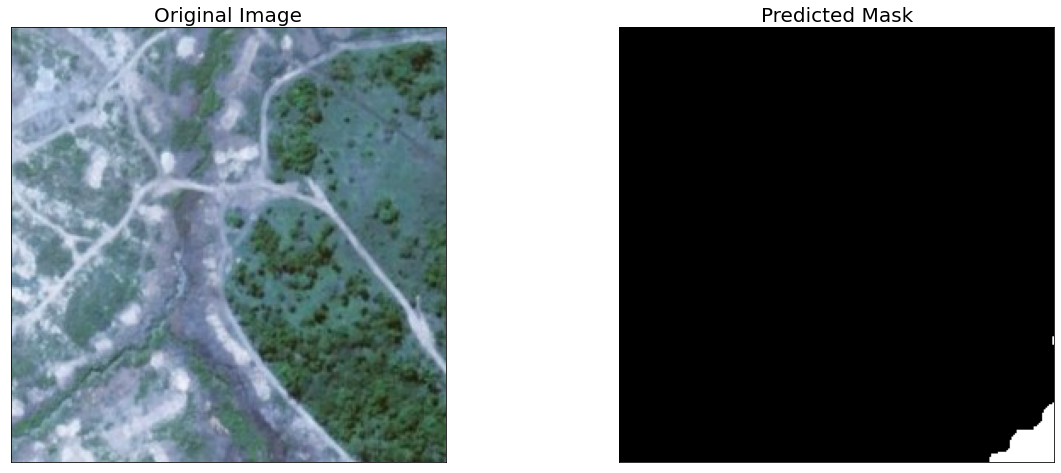

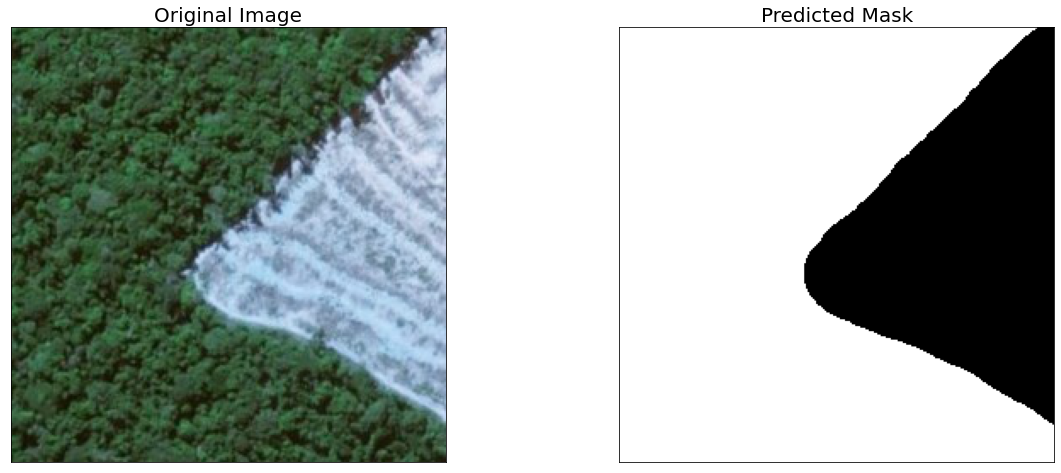

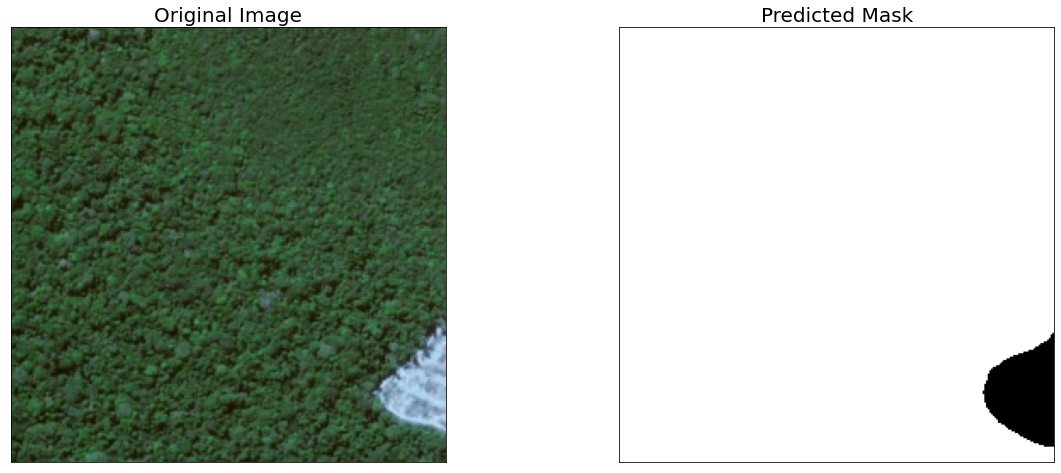

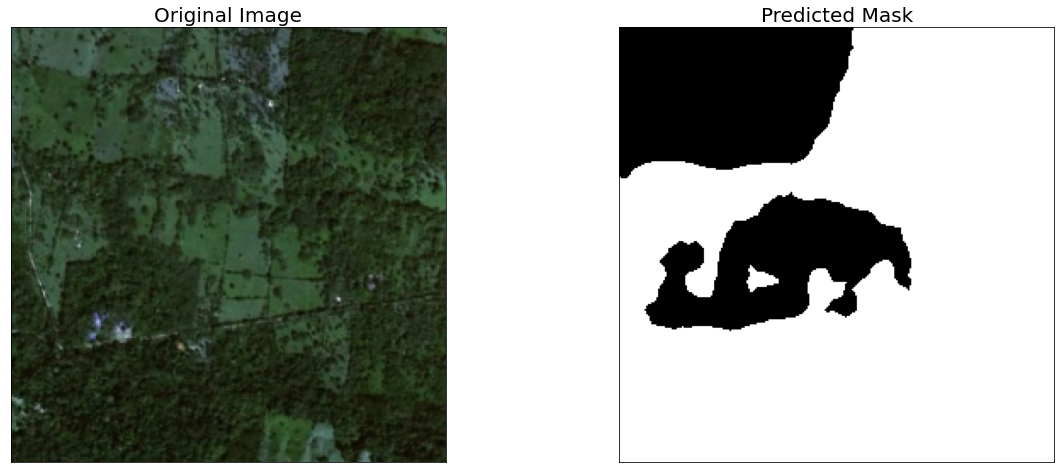

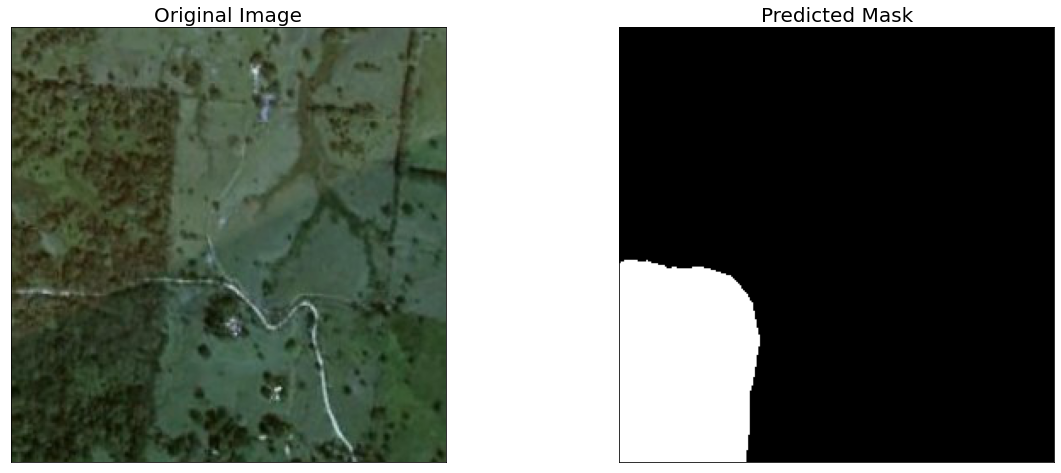

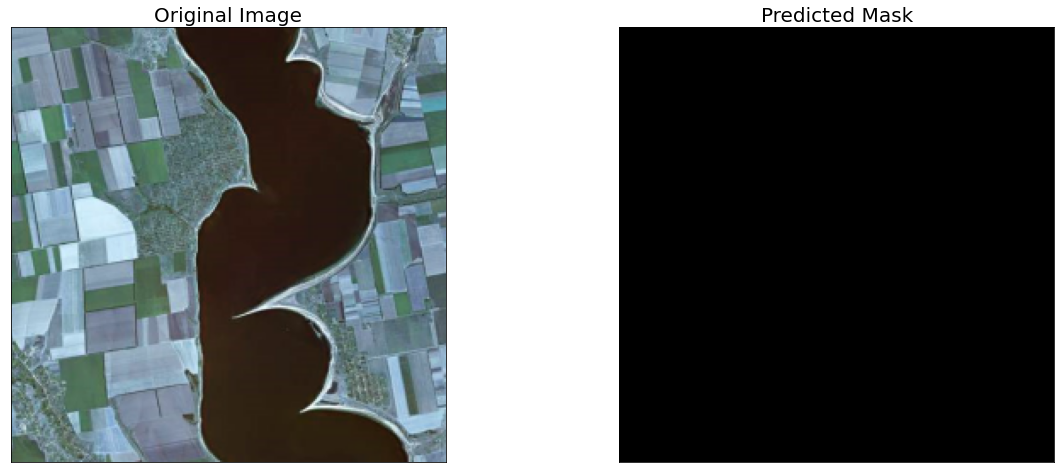

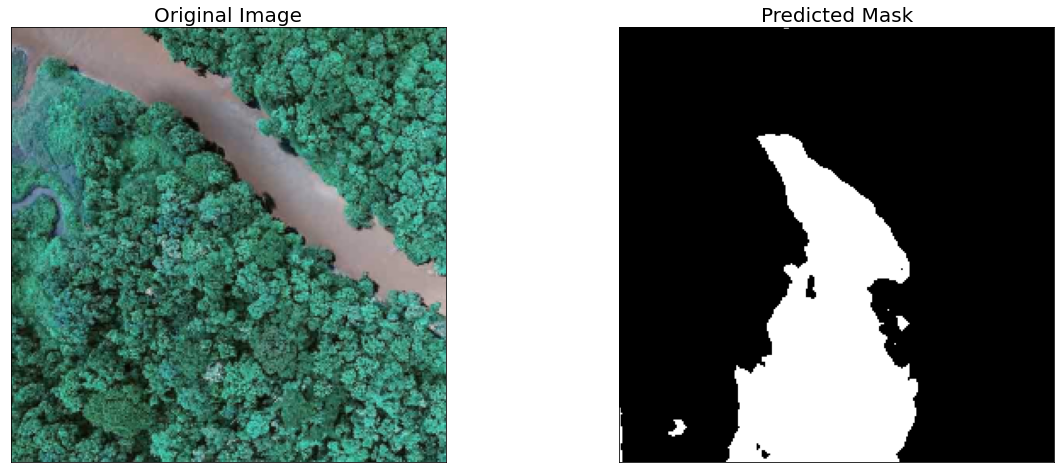

In [ ]:
custom_data_predictions_folder = PRETRAINED_MODELS_DIR+'/custom_data_predictions'
if not os.path.exists(custom_data_predictions_folder):
    os.makedirs(custom_data_predictions_folder)

if (VISUALIZE_VALID):
  print('Valid Dataset Count: '+str(len(custom_dataset)))

  for idx in range(len(custom_dataset)):
    image = custom_dataset[idx]
    image_vis = custom_dataset_vis[idx].astype('uint8')

    # Görüntünün yeniden boyutlandırılması
    dim = (256, 256)
    print('Original Dimensions : ',image.shape)
    resized = cv2.resize(image_vis, dim, interpolation = cv2.INTER_AREA)
    print('Resized Dimensions : ',resized.shape)
    visualize(
        Orjinal_image = image_vis,
        Resized_image = resized
    )

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Custom/Doğrulama görüntüsünün modele girdi olarak verilmesi (tahmin işlemi)
    pred_mask = model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Tahmin edilen maske çıktısının CHW formatından HWC formatına dönüştürülmesi.
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Tahmin edilen maskeye tersine one hot encoding (one hot decoding) uygulanması,
    # ve veri setindeki segment renklerine göre renklendirilmesi.
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    #Dosyaya yazma.
    cv2.imwrite(os.path.join(custom_data_predictions_folder, f"custom_pred_{idx}.png"), np.hstack([image_vis, resized, pred_mask])[:,:,::-1])
    #Görselleştirme
    visualize(
        original_image = image_vis,
        Resized_image = resized,
        predicted_mask = pred_mask
    )

### Model Evaluation on Test Dataset

In [ ]:
#Modelin test veri seti üzerinde eğitim yapılmadan, başarım metriklerinin ölçülmesi.
#test_epoch = smp.utils.train.ValidEpoch(
#    model,
#    loss=loss, 
#    metrics=metrics, 
#    device=DEVICE,
#    verbose=True,
#)

#valid_logs = test_epoch.run(test_dataloader)
#print("Evaluation on Test Data: ")
#print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
#print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

### Plot Dice Loss & IoU Metric for Train vs. Val

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)

In [ ]:
print('Train Logs')
train_logs_df.T

In [ ]:
print('Validation Logs')
valid_logs_df.T

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig(PRETRAINED_MODELS_DIR+'/iou_score_plot.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig(PRETRAINED_MODELS_DIR+'/dice_loss_plot.png')
plt.show()